### Import Libraries and Data

In [1]:
import zipfile
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,RNN
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
from datetime import datetime
import pytz
from tensorflow.keras.callbacks import LearningRateScheduler,TensorBoard,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,Nadam
import warnings
warnings.filterwarnings('ignore')
import nltk.translate.bleu_score as bleu
import random
from tqdm import tqdm
import shutil
import io
from nltk.translate.gleu_score import sentence_gleu
import pickle

In [2]:
final_df = pd.read_csv('C:/Users/prash/Desktop/New_now100/data/final_df_preprocessed_2021111201.csv')

In [3]:
final_df = final_df[final_df['incorrect_word_count'] <= 12]
final_df.shape

(3231, 6)

In [4]:
final_df = final_df[['correct','incorrect']]

In [5]:
final_df[final_df.isna().any(axis=1)]

,correct,incorrect


###  Train Test Split

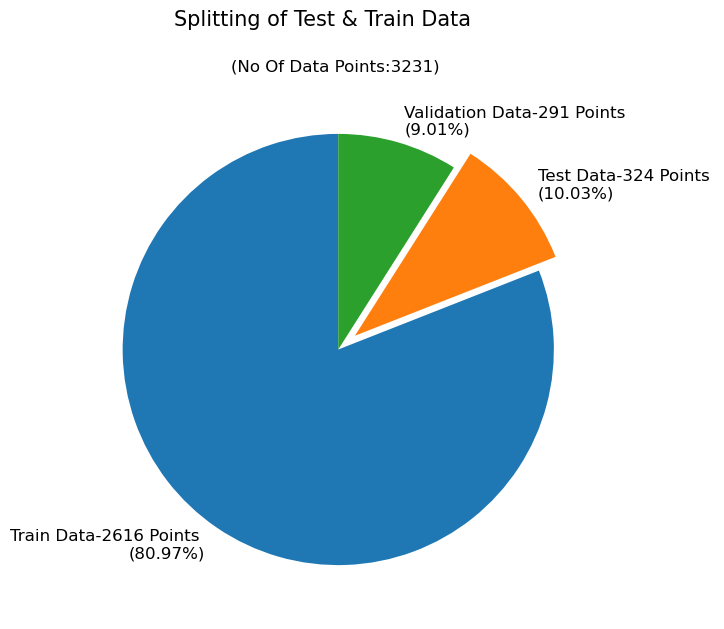

In [6]:
train,test = train_test_split(final_df, test_size=0.1,random_state=15)
train,validation = train_test_split(train, test_size=0.1)
fig,ax = plt.subplots(figsize =(10, 7))
labels_split = ['Train', 'Test','Validation'] 
sizes_split = [len(train),len(test),len(validation)]
pcts_split = [f'{l} Data-{s} Points \n({s*100/sum(sizes_split):.2f}%)' for s,l in zip(sizes_split, labels_split)] 
ax.pie(sizes_split, labels = pcts_split, startangle = 90, 
       explode=(0,0.1,0),textprops = {"fontsize":12} )

plt.suptitle(f'Splitting of Test & Train Data ', fontsize = 15)
plt.title(f'(No Of Data Points:{sum(sizes_split)}) ', fontsize = 12)
plt.show()

In [7]:
train['dec_correct_inp'] = '<start> ' + train['correct'].astype(str)
train['dec_correct_out'] = train['correct'].astype(str) + ' <end>'

validation['dec_correct_inp'] = '<start> ' + validation['correct'].astype(str)
validation['dec_correct_out'] = validation['correct'].astype(str) + ' <end>'

test['dec_correct_inp'] = '<start> ' + test['correct'].astype(str)
test['dec_correct_out'] = test['correct'].astype(str) + ' <end>'

In [8]:
train.sample(5)

,correct,incorrect,dec_correct_inp,dec_correct_out
4319,Next up my search vegetarian poutine & to visi...,Next up my search for vegetarian poutine & vis...,<start> Next up my search vegetarian poutine &...,Next up my search vegetarian poutine & to visi...
2734,How to have the Great time on you Forida Carac...,How to have the Great time on your Florida Vac...,<start> How to have the Great time on you Fori...,How to have the Great time on you Forida Carac...
1114,Last edited by Klyde at PM.,Last edited by Klyde at PM.,<start> Last edited by Klyde at PM.,Last edited by Klyde at PM. <end>
5844,ãLies can naver changes fact.,ãLies can never changes fact.,<start> ãLies can naver changes fact.,ãLies can naver changes fact. <end>
3322,Kafui Celko Wireless Sprint Spectrum of Lodging.,Kafui Celko Wireless Sprint Spectrum L.P.,<start> Kafui Celko Wireless Sprint Spectrum o...,Kafui Celko Wireless Sprint Spectrum of Lodgin...


In [9]:
test.sample(5)

,correct,incorrect,dec_correct_inp,dec_correct_out
6412,Quesetion from where do comes the money for w...,Question where does the money to run this Inst...,<start> Quesetion from where do comes the mone...,Quesetion from where do comes the money for w...
2130,Q What is job includd in the rate?,Q What is included in the rate?,<start> Q What is job includd in the rate?,Q What is job includd in the rate? <end>
6953,Yeast with changed to petri dishes.,Yeast is added to the petri dishes.,<start> Yeast with changed to petri dishes.,Yeast with changed to petri dishes. <end>
8406,A colouring book of wrecked.,A colouring book about Paul is shipwreck.,<start> A colouring book of wrecked.,A colouring book of wrecked. <end>
5441,a Ireland x hisotry y v fit early works to .,a Ireland x History y v Early works to .,<start> a Ireland x hisotry y v fit early work...,a Ireland x hisotry y v fit early works to . <...


In [10]:
validation.sample(5)

,correct,incorrect,dec_correct_inp,dec_correct_out
5587,See what our students talk about studying at J...,See what our students say about studying at JIBC.,<start> See what our students talk about study...,See what our students talk about studying at J...
78,Over Tv channels and raditised channels See ch...,Over TV channels and radio channels See BT Vis...,<start> Over Tv channels and raditised channel...,Over Tv channels and raditised channels See ch...
805,So I have some here,"So, I have some here.",<start> So I have some here,So I have some here <end>
168,What is Common Symptoms of Indoor Air Pollution?,What Are Some Common Symptoms of Indoor Air Po...,<start> What is Common Symptoms of Indoor Air ...,What is Common Symptoms of Indoor Air Pollutio...
3833,ANC is Dakota Legoete is reasons me for the AN...,ANC is Dakota Legoete gives reasons for the AN...,<start> ANC is Dakota Legoete is reasons me fo...,ANC is Dakota Legoete is reasons me for the AN...


In [11]:
train.to_csv('C:/Users/prash/Desktop/New_now100/data/train_20211112.csv')
validation.to_csv('C:/Users/prash/Desktop/New_now100/data/validation_20211112.csv')
test.to_csv('C:/Users/prash/Desktop/New_now100/data/test_20211112.csv')

### Tokenizer

In [12]:
tokenizer_enc = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n',lower=False)
tokenizer_enc.fit_on_texts(train['incorrect'].astype(str).values)

In [13]:
tokenizer_dec = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n',lower=False)
tokenizer_dec.fit_on_texts(train['dec_correct_inp'].astype(str).values)

In [14]:
vocab_size_enc=len(tokenizer_enc.word_index.keys())
print('Encoder words vocab size:',vocab_size_enc)

Encoder words vocab size: 9465


In [15]:
vocab_size_dec=len(tokenizer_dec.word_index.keys())
print('Decoder words vocab size::',vocab_size_dec)

Decoder words vocab size:: 9747


In [16]:
tokenizer_dec.word_index['<start>'],tokenizer_dec.word_index.get('<end>', None)

(1, None)

In [17]:
tokenizer_dec.word_index['<end>'] = max(tokenizer_dec.word_index.values()) + 1

In [18]:
with open('C:/Users/prash/Desktop/New_now100/data/tokenizer_enc_20211112.pkl', 'wb') as f:
  pickle.dump(tokenizer_enc, f)

with open('C:/Users/prash/Desktop/New_now100/data/tokenizer_dec_20211112.pkl', 'wb') as f:
  pickle.dump(tokenizer_dec, f)

In [19]:
tokenizer_enc = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n',lower=False)
tokenizer_enc.fit_on_texts(train['incorrect'].astype(str).values)
tokenizer_dec = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n',lower=False)
tokenizer_dec.fit_on_texts(train['dec_correct_inp'].astype(str).values)

vocab_size_enc=len(tokenizer_enc.word_index.keys())
print('Encoder words vocab size:',vocab_size_enc)
vocab_size_dec=len(tokenizer_dec.word_index.keys())
print('Decoder words vocab size::',vocab_size_dec)

tokenizer_dec.word_index['<start>'],tokenizer_dec.word_index.get('<end>', None)
tokenizer_dec.word_index['<end>'] = max(tokenizer_dec.word_index.values()) + 1

#text2seq
train_enc_inp = tokenizer_enc.texts_to_sequences(train['incorrect'].astype(str).values)
validation_enc_inp = tokenizer_enc.texts_to_sequences(validation['incorrect'].astype(str).values)
test_enc_inp = tokenizer_enc.texts_to_sequences(test['incorrect'].astype(str).values)

#padding
max_seq_len = 12
train_enc_inp = pad_sequences(train_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')
validation_enc_inp = pad_sequences(validation_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')

#text2seq
train_dec_inp = tokenizer_dec.texts_to_sequences(train['dec_correct_inp'].astype(str).values)
validation_dec_inp = tokenizer_dec.texts_to_sequences(validation['dec_correct_inp'].astype(str).values)

#padding
train_dec_inp = pad_sequences(train_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_inp = pad_sequences(validation_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')

#text2seq
train_dec_out = tokenizer_dec.texts_to_sequences(train['dec_correct_out'].astype(str).values)
validation_dec_out = tokenizer_dec.texts_to_sequences(validation['dec_correct_out'].astype(str).values)

#padding
train_dec_out = pad_sequences(train_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_out = pad_sequences(validation_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')

Encoder words vocab size: 9465
Decoder words vocab size:: 9747


### Text to Sequence

Mean Word Count:8.409403669724771


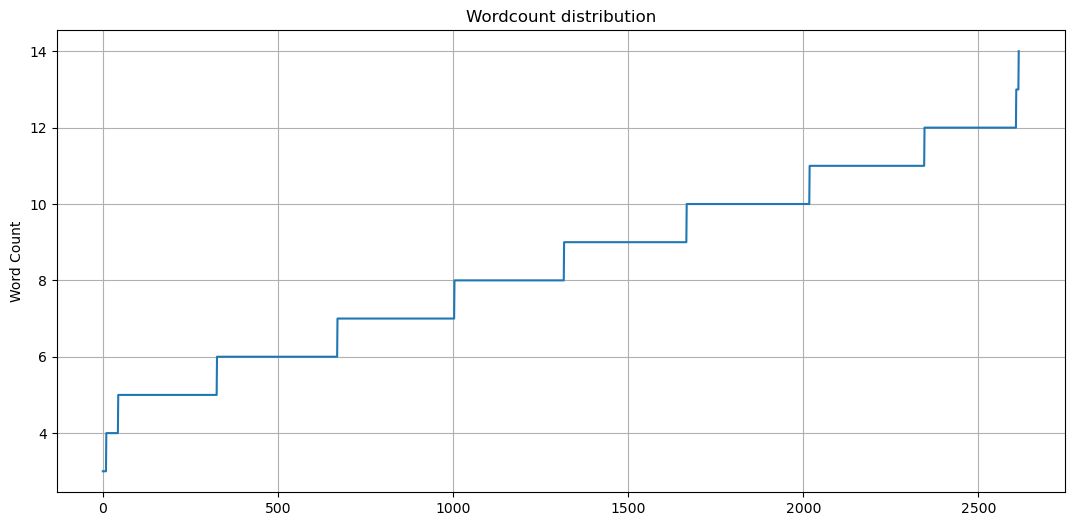

In [20]:
content=train['incorrect'].astype('str')
content_word_count=[len(content.iloc[i].split()) for i in range(len(content))]
mean_word_count=np.mean(content_word_count)
print(f'Mean Word Count:{mean_word_count}')
index=[i for i in range(0,len(content_word_count))]
fig, ax=plt.subplots(figsize=(13, 6))
plt.plot(index,sorted(content_word_count))
plt.grid()
plt.title("Wordcount distribution")
plt.ylabel("Word Count")
plt.show()

In [21]:
#text2seq
train_enc_inp = tokenizer_enc.texts_to_sequences(train['incorrect'].astype(str).values)
validation_enc_inp = tokenizer_enc.texts_to_sequences(validation['incorrect'].astype(str).values)
test_enc_inp = tokenizer_enc.texts_to_sequences(test['incorrect'].astype(str).values)

#padding
max_seq_len = 12
train_enc_inp = pad_sequences(train_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')
validation_enc_inp = pad_sequences(validation_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')
test_enc_inp = pad_sequences(test_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')

In [22]:
#text2seq
train_dec_inp = tokenizer_dec.texts_to_sequences(train['dec_correct_inp'].astype(str).values)
validation_dec_inp = tokenizer_dec.texts_to_sequences(validation['dec_correct_inp'].astype(str).values)
test_dec_inp = tokenizer_dec.texts_to_sequences(test['dec_correct_inp'].astype(str).values)

#padding
train_dec_inp = pad_sequences(train_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_inp = pad_sequences(validation_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')
test_dec_inp = pad_sequences(test_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')

In [23]:
#text2seq
train_dec_out = tokenizer_dec.texts_to_sequences(train['dec_correct_out'].astype(str).values)
validation_dec_out = tokenizer_dec.texts_to_sequences(validation['dec_correct_out'].astype(str).values)
test_dec_out = tokenizer_dec.texts_to_sequences(test['dec_correct_out'].astype(str).values)

#padding
train_dec_out = pad_sequences(train_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_out = pad_sequences(validation_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')
test_dec_out = pad_sequences(test_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')

In [24]:
with open('C:/Users/prash/Desktop/New_now100/data/train_enc_inp_20211112.pkl', 'wb') as f:
  pickle.dump(train_enc_inp, f)

with open('C:/Users/prash/Desktop/New_now100/data/val_enc_inp_20211112.pkl', 'wb') as f:
  pickle.dump(validation_enc_inp, f)

with open('C:/Users/prash/Desktop/New_now100/data/test_enc_inp_20211112.pkl', 'wb') as f:
  pickle.dump(test_enc_inp, f)

In [25]:
with open('C:/Users/prash/Desktop/New_now100/data/train_dec_inp_20211112.pkl', 'wb') as f:
  pickle.dump(train_dec_inp, f)

with open('C:/Users/prash/Desktop/New_now100/data/val_dec_inp_20211112.pkl', 'wb') as f:
  pickle.dump(validation_dec_inp, f)

with open('C:/Users/prash/Desktop/New_now100/data/test_dec_inp_20211112.pkl', 'wb') as f:
  pickle.dump(test_dec_inp, f)

In [26]:
with open('C:/Users/prash/Desktop/New_now100/data/train_dec_out_20211112.pkl', 'wb') as f:
  pickle.dump(train_dec_out, f)

with open('C:/Users/prash/Desktop/New_now100/data/val_dec_out_20211112.pkl', 'wb') as f:
  pickle.dump(validation_dec_out, f)

with open('C:/Users/prash/Desktop/New_now100/data/test_dec_out_20211112.pkl', 'wb') as f:
  pickle.dump(test_dec_out, f)